# ***Reza Dalir - 610300050***
# ***AI course Project: Brain MRI Segmentation***
***

### **Download the datatset from kaggle:**

In [1]:
import kagglehub
path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

print("Path to dataset files:", path)

100%|██████████| 714M/714M [00:18<00:00, 41.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2


***
### **Required libraries:**

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random

import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import adjusted_rand_score

***
### ***Step 0.1: preparing iamge paths***

In [2]:
root = "/root/.cache/kagglehub/datasets/mateuszbuda/lgg-mri-segmentation/versions/2/kaggle_3m"
imagePaths = []
maskPaths = []

def extract_number(filename):
    parts = filename.replace(".tif", "").split('_')
    for part in reversed(parts):
        if part.isdigit():
            last_num = int(part)
            break
    return last_num

for folder in os.listdir(root):
    mask = []
    img = []
    for file in os.listdir(root+'/'+folder):
        if "mask" in file:
            mask.append((folder, file))
        else:
            img.append((folder, file))
    img = sorted(img, key=lambda x: extract_number(x[1]))
    mask = sorted(mask, key=lambda x: extract_number(x[1]))
    imagePaths.append(img)
    maskPaths.append(mask)

print(imagePaths[23])
print(maskPaths[23])

[('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_1.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_2.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_3.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_4.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_5.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_6.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_7.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_8.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_9.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_10.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_11.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_12.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_13.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_14.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_15.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_16.tif'), ('TCGA_FG_5962_20000626', 'TCGA_FG_5962_20000626_17.tif'), ('TCG

## **1. Dataset Familiarization**

[20, 38, 37, 30, 46, 5, 22, 28, 11, 5]
51


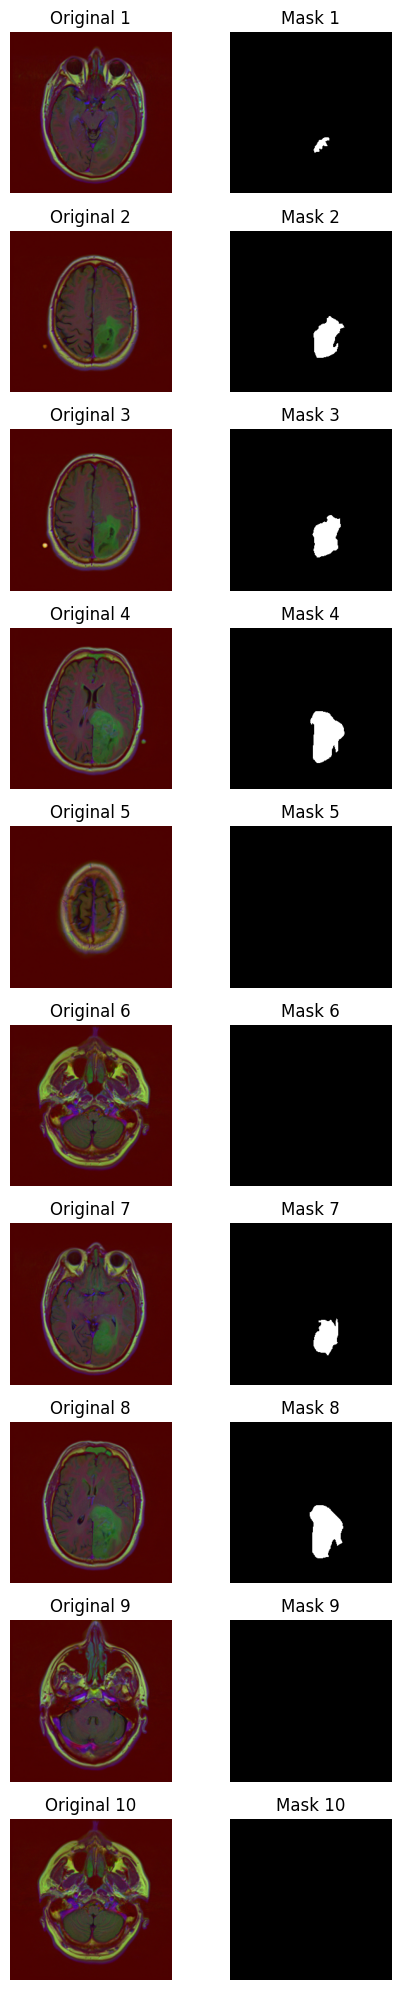

In [ ]:
indexes = [random.randint(1, len(imagePaths[23])-1) for _ in range(10)]
print(indexes)
print(len(imagePaths[23]))
imageSample = [imagePaths[23][i] for i in indexes]
maskSample = [maskPaths[23][i] for i in indexes]

plt.figure(figsize=(5, 20))
for i in range(10):
    img_array = np.array(Image.open(root + '/' + imageSample[i][0] + '/' + imageSample[i][1]))
    mask_array = np.array(Image.open(root + '/' + maskSample[i][0] + '/' + maskSample[i][1]))
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(img_array, cmap='gray')
    plt.title(f"Original {i+1}")
    plt.axis("off")

    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(mask_array)
    plt.title(f"Mask {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

***
### ***Step 1.1: preprocessing the dataset***

In [3]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

def preprocess_image(img_path):
    img = np.array(Image.open(img_path).convert('L'))
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img = clahe.apply((img * 255).astype(np.uint8)) / 255.0
    img = cv2.GaussianBlur(img, (3, 3), 0)
    return img

preprocessedImages = [preprocess_image(root + '/' + imagePaths[j][i][0] + '/' + imagePaths[j][i][1]) for j in range(len(imagePaths))  for i in range(len(imagePaths[j])) ]
preprocessedMasks = [preprocess_image(root + '/' + maskPaths[j][i][0] + '/' + maskPaths[j][i][1]) for j in range(len(maskPaths)) for i in range(len(maskPaths[j]))]

## ***Comparing preprocesses images with the original ones:***

Images:  [19, 14, 12, 46, 29, 30, 24, 39, 36, 45]


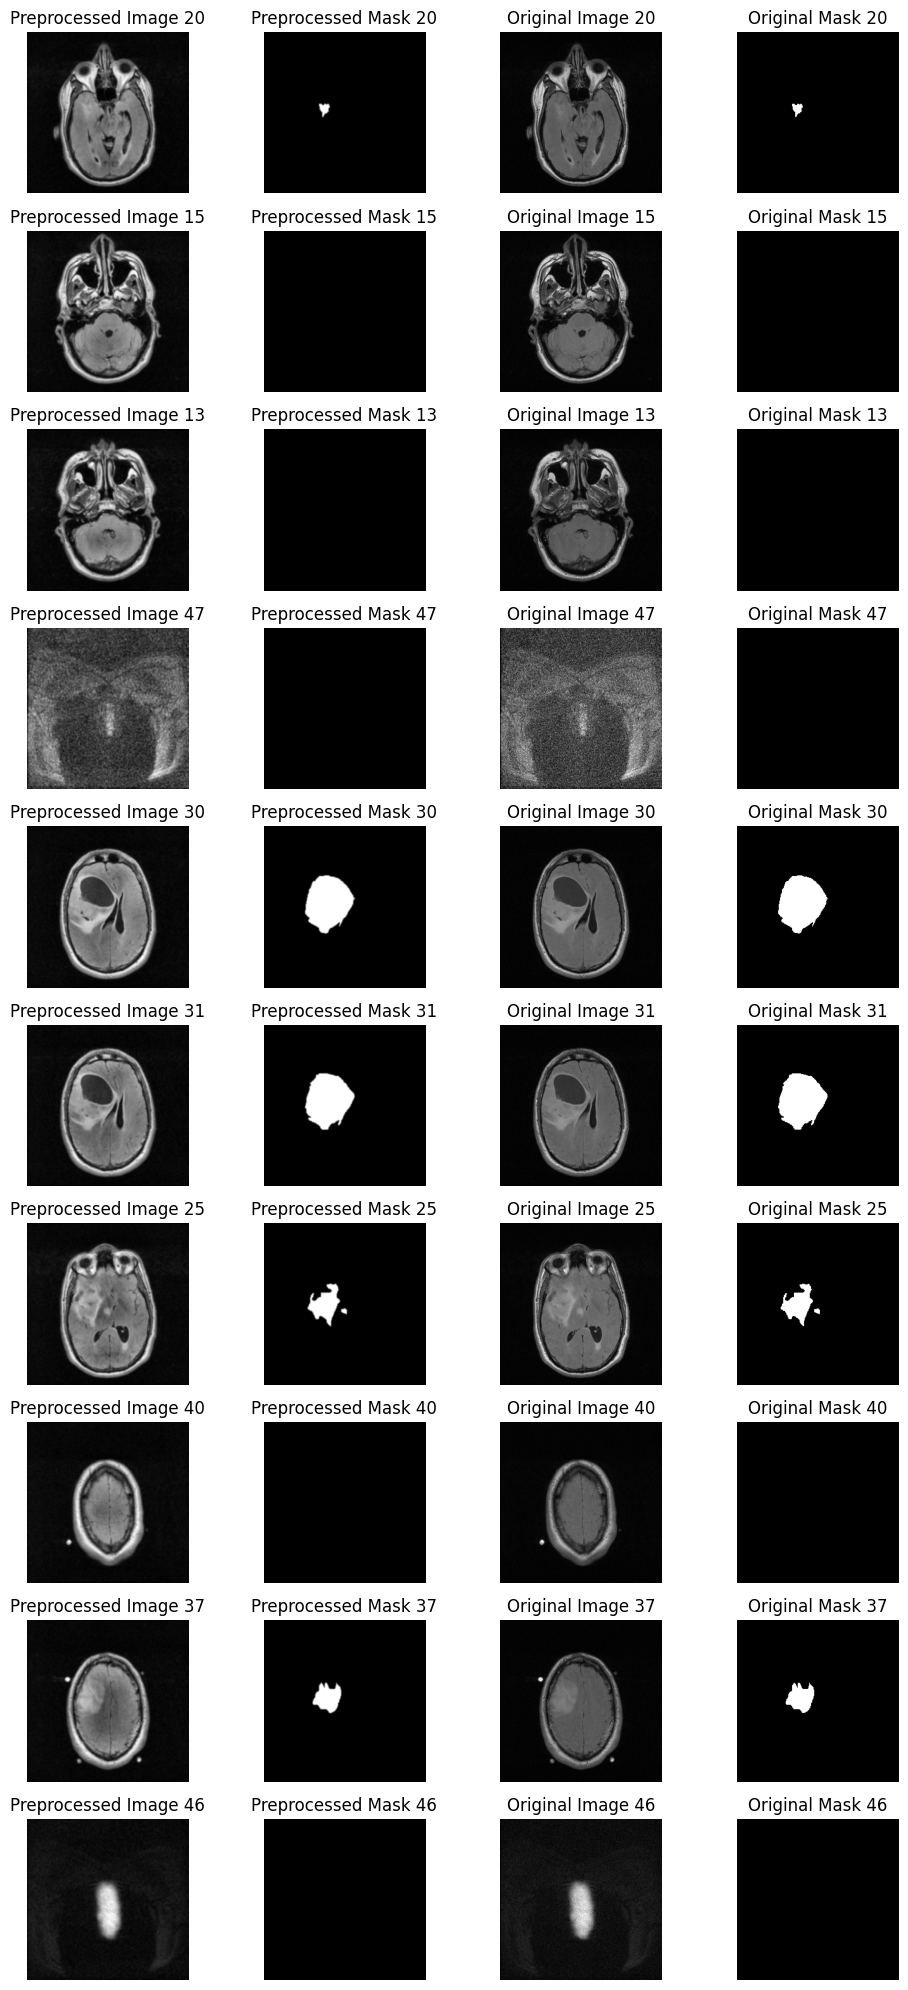

In [ ]:
indexes = random.sample(range(len(imagePaths[0])), 10)
print("Images: ", indexes)

plt.figure(figsize=(10, 20))
j = 1
for i in indexes:
    plt.subplot(10, 4, j)
    plt.imshow(preprocessedImages[i], cmap='gray')
    plt.title(f"Preprocessed Image {i+1}")
    plt.axis("off")

    plt.subplot(10, 4, j+1)
    plt.imshow(preprocessedMasks[i], cmap='gray')
    plt.title(f"Preprocessed Mask {i+1}")
    plt.axis("off")

    plt.subplot(10, 4, j+2)
    plt.imshow(Image.open(root + '/' + imagePaths[0][i][0] + '/' + imagePaths[0][i][1]).convert('L'), cmap='gray')
    plt.title(f"Original Image {i+1}")
    plt.axis("off")

    plt.subplot(10, 4, j+3)
    plt.imshow(Image.open(root + '/' + maskPaths[0][i][0] + '/' + maskPaths[0][i][1]).convert('L'), cmap='gray')
    plt.title(f"Original Mask {i+1}")
    plt.axis("off")

    j += 4
plt.tight_layout()
plt.show()

***
## ***Step 1.2: split train, validation and test set with ratio 80, 10, 10 percent:***

In [4]:
preprocessedImages = np.array(preprocessedImages)
preprocessedMasks = np.array(preprocessedMasks) > 0.5

indices = np.arange(len(preprocessedImages))
np.random.shuffle(indices)

preprocessedImages = preprocessedImages[indices]
preprocessedMasks = preprocessedMasks[indices]

train_size = int(0.8 * len(preprocessedImages))
valSize = int(0.9 * len(preprocessedImages))
X_train, Y_train = preprocessedImages[:train_size], preprocessedMasks[:train_size]
X_val, Y_val = preprocessedImages[train_size:valSize], preprocessedMasks[train_size:valSize]
X_test, Y_test = preprocessedImages[valSize:], preprocessedMasks[valSize:]

***
### ***Resize the train validation and test set to a proper form for U_Net model***

In [5]:
X_train = np.expand_dims(X_train, axis=-1)
Y_train = np.expand_dims(Y_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
Y_val = np.expand_dims(Y_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
Y_test = np.expand_dims(Y_test, axis=-1)
X_train.shape

(3143, 256, 256, 1)

***
### ***Step 2.1: implement the model***

In [6]:
def U_Net():
    f = [16, 32, 64, 128, 256]
    # ENCODER part
    # input layer
    inputs = tf.keras.layers.Input((256, 256, 1))

    # layer 1
    c1 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    # layer 2
    c2 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    # layer 3
    c3 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    # layer 4
    c4 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # bottleneck
    # layer 5
    c5 = tf.keras.layers.Conv2D(f[4], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(f[4], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = tf.keras.layers.Dropout(0.3)(c5)

    # DECODER part
    # layer 6
    u6 = tf.keras.layers.Conv2DTranspose(f[3], (3,3), strides=(2,2), padding='same')(c5)
    u6 = tf.keras.layers.Concatenate()([u6, c4])
    c6 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # layer 7
    u7 = tf.keras.layers.Conv2DTranspose(f[2], (3,3), strides=(2,2), padding='same')(c6)
    u7 = tf.keras.layers.Concatenate()([u7, c3])
    c7 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # layer 8
    u8 = tf.keras.layers.Conv2DTranspose(f[1], (3,3), strides=(2,2), padding='same')(c7)
    u8 = tf.keras.layers.Concatenate()([u8, c2])
    c8 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    # layer 9
    u9 = tf.keras.layers.Conv2DTranspose(f[0], (3,3), strides=(2,2), padding='same')(c8)
    u9 = tf.keras.layers.Concatenate()([u9, c1])
    c9 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # output layer
    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [7]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('U-Net-model.h5.keras', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')]

***
## ***Evaluation metrices:***

In [8]:
def IoU(y_true, y_pred):
    intersection = np.sum((y_true > 0) & (y_pred > 0))
    union = np.sum((y_true > 0) | (y_pred > 0))
    return intersection / (union + 1e-6)

def dice_coefficient(y_true, y_pred):
    intersection = np.sum((y_true > 0) & (y_pred > 0))
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred) + 1e-6)

def pixel_error(y_true, y_pred):
    misclassified_pixels = np.sum(y_true != y_pred)
    total_pixels = y_true.size
    return misclassified_pixels / total_pixels

def rand_error(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.bool)
    y_pred = tf.cast(y_pred > 0.5, tf.bool)
    intersection = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    rand_error = 1 - (intersection / tf.cast(tf.size(y_true), tf.float32))

    return rand_error.numpy()

## ***Evaluate function:***

In [9]:
def evaluate_model_performance(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(np.uint8)
    y_true = (y_true > 0.5).astype(np.uint8)
    iou = IoU(y_true, y_pred)
    dice = dice_coefficient(y_true, y_pred)
    rand = rand_error(y_true, y_pred)
    pixel_err = pixel_error(y_true, y_pred)

    print(f"IoU: {iou}")
    print(f"Dice Coefficient: {dice}")
    print(f"Rand Error: {rand}")
    print(f"Pixel Error: {pixel_err}")


***
## ***Plot function:***

In [10]:
def plot_the_result(y_pred, Y_result, X_result, num_sample = 10):
    plt.figure(figsize=(7, 20))
    j = 1
    for i in range(num_sample):
        plt.subplot(10, 3, j)
        plt.imshow(y_pred[i] > 0.5, cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis("off")

        plt.subplot(10, 3, j+1)
        plt.imshow(Y_result[i], cmap='gray')
        plt.title(f"Real Mask {i+1}")
        plt.axis("off")

        plt.subplot(10, 3, j+2)
        plt.imshow(X_result[i], cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis("off")

        j += 3

    plt.tight_layout()
    plt.show()

***
## **Train the model with weighted dice and BCE as loss function:**

In [11]:
def dice_bce_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return 0.5 * bce + 0.5 * dice_loss


In [12]:
U_Net_model = U_Net()
U_Net_model.compile(optimizer='adam', loss=dice_bce_loss, metrics=['accuracy'])
U_Net_results = U_Net_model.fit(X_train,
                                Y_train,
                                validation_data=(X_val, Y_val),
                                batch_size=16,
                                epochs=15,
                                callbacks=callbacks)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


197/197 ━━━━━━━━━━━━━━━━━━━━ 85s 277ms/step - accuracy: 0.9901 - loss: 0.5489 - val_accuracy: 0.9853 - val_loss: 0.4383
Epoch 2/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - accuracy: 0.9832 - loss: 0.4310 - val_accuracy: 0.9801 - val_loss: 0.3993
Epoch 3/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - accuracy: 0.9802 - loss: 0.4077 - val_accuracy: 0.9849 - val_loss: 0.3583
Epoch 4/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.9866 - loss: 0.3651 - val_accuracy: 0.9898 - val_loss: 0.4940
Epoch 5/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.9894 - loss: 0.3426 - val_accuracy: 0.9884 - val_loss: 0.2963
Epoch 6/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.9907 - loss: 0.2927 - val_accuracy: 0.9906 - val_loss: 0.2480
Epoch 7/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.9906 - loss: 0.2658 - val_accuracy: 0.9910 - val_loss: 0.2405
Epoch 8/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.9914 - loss: 0.2590 - val

***
## ***results on the trianset:***

In [13]:
train_y_pred = U_Net_model.predict(X_train)
evaluate_model_performance(Y_train, train_y_pred)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 256, 256, 1))
  warnings.warn(msg)


99/99 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step
IoU: 0.5715113968797438
Dice Coefficient: 0.7273398055075987
Rand Error: 0.0048580169677734375
Pixel Error: 0.004858159578950246


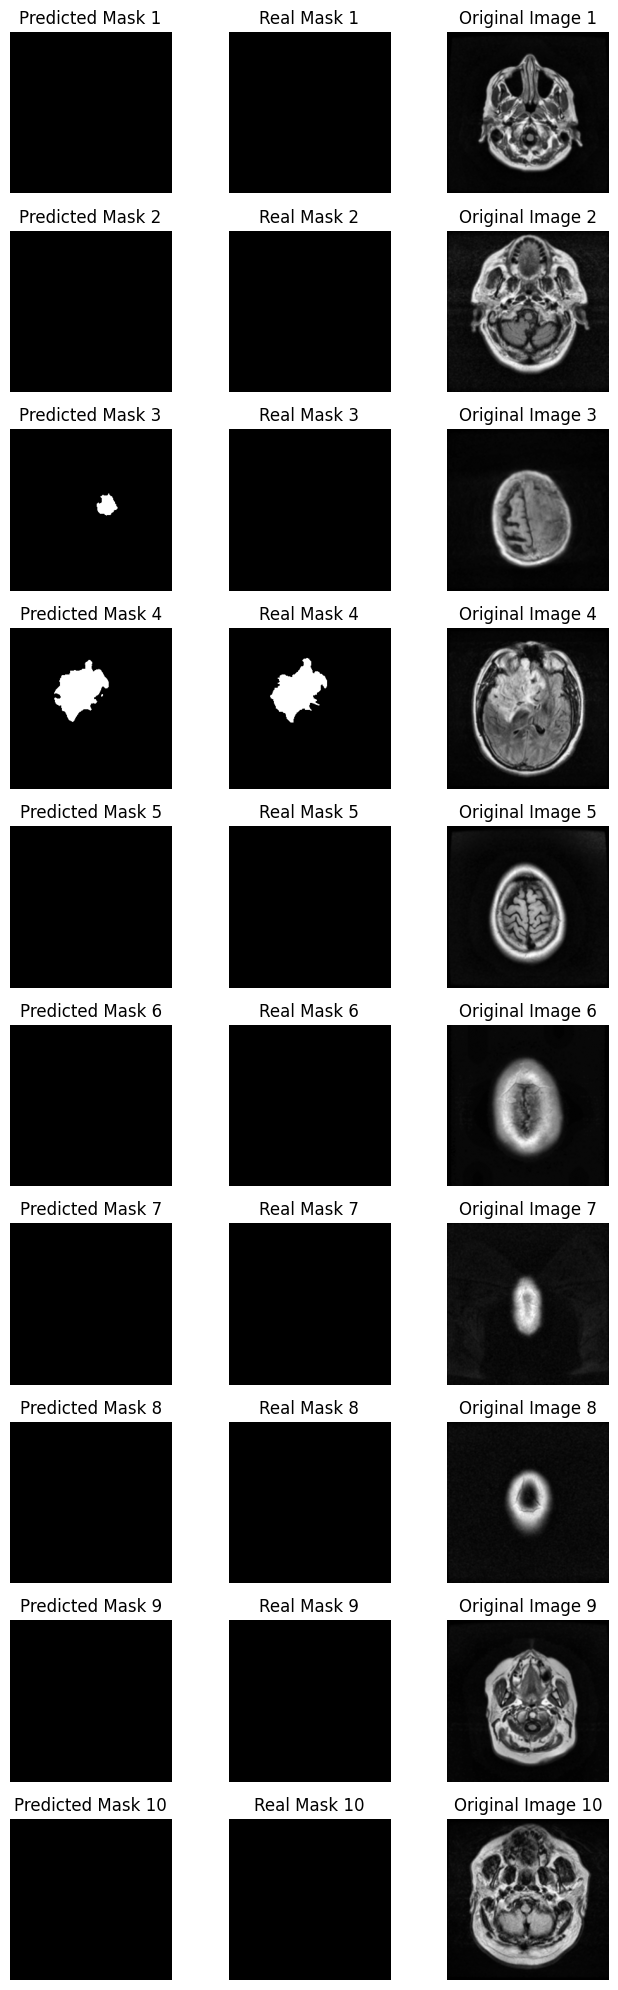

In [14]:
plot_the_result(train_y_pred, Y_train, X_train)

***
## ***results on the testset:***

In [15]:
y_pred = U_Net_model.predict(X_test)
evaluate_model_performance(Y_test, y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
IoU: 0.5626133903178764
Dice Coefficient: 0.7200928826079317
Rand Error: 0.005419731140136719
Pixel Error: 0.005419704446962468


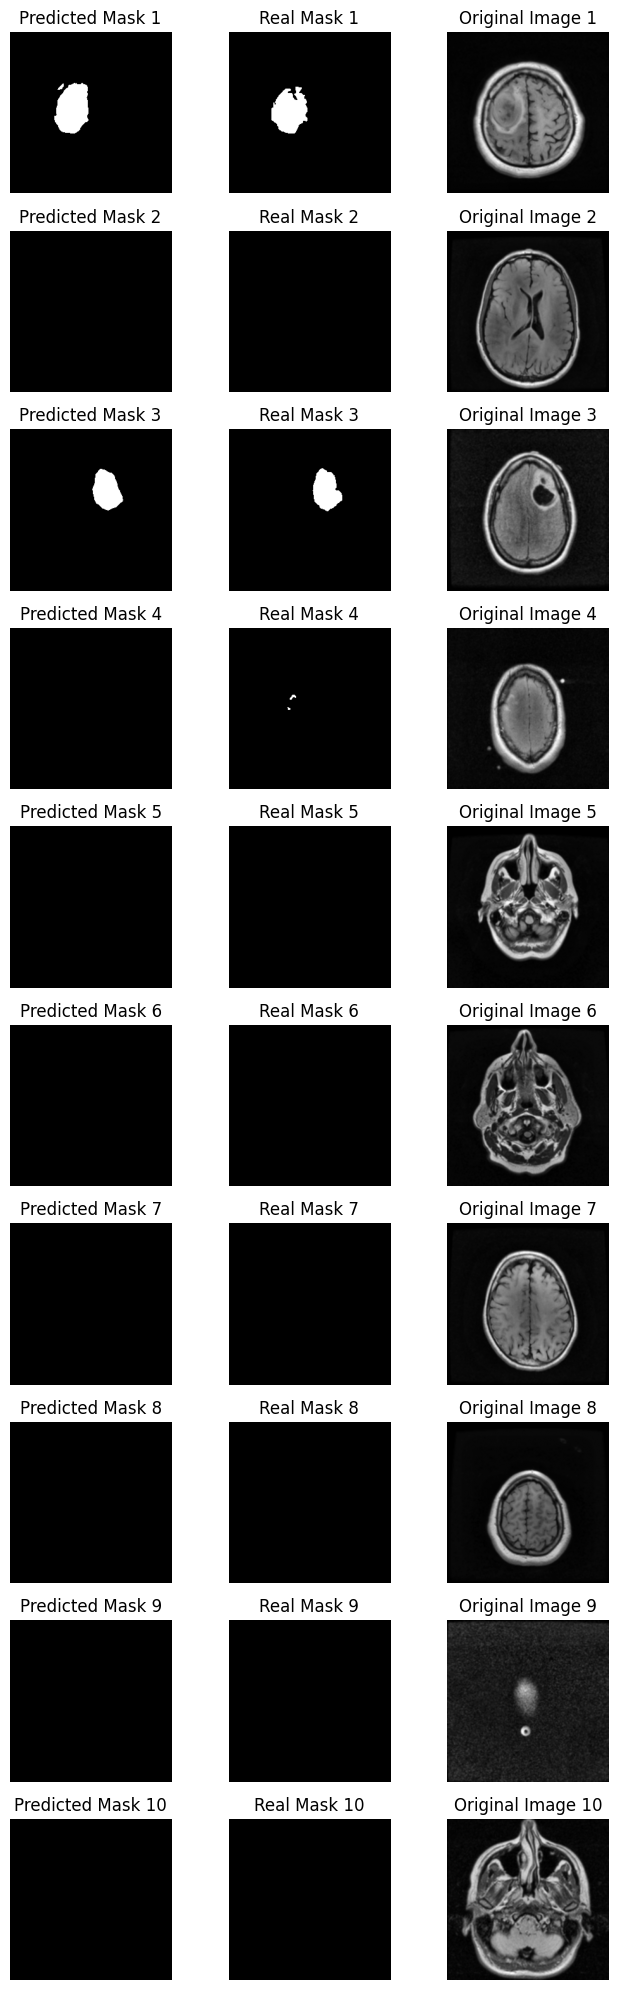

In [16]:
plot_the_result(y_pred, Y_test, X_test)

***
## ***Using binary crossentropy as the loss function:***

In [17]:
U_Net_model = U_Net()
U_Net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
U_Net_results = U_Net_model.fit(X_train,
                                Y_train,
                                validation_data=(X_val, Y_val),
                                batch_size=16,
                                epochs=15,
                                callbacks=callbacks)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_41']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


197/197 ━━━━━━━━━━━━━━━━━━━━ 62s 216ms/step - accuracy: 0.9849 - loss: 0.1086 - val_accuracy: 0.9892 - val_loss: 0.0483
Epoch 2/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - accuracy: 0.9901 - loss: 0.0397 - val_accuracy: 0.9892 - val_loss: 0.0354
Epoch 3/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.9899 - loss: 0.0355 - val_accuracy: 0.9892 - val_loss: 0.0377
Epoch 4/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.9899 - loss: 0.0343 - val_accuracy: 0.9892 - val_loss: 0.0322
Epoch 5/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.9905 - loss: 0.0272 - val_accuracy: 0.9913 - val_loss: 0.0271
Epoch 6/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9920 - loss: 0.0248 - val_accuracy: 0.9926 - val_loss: 0.0224
Epoch 7/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9937 - loss: 0.0195 - val_accuracy: 0.9937 - val_loss: 0.0198
Epoch 8/15
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9939 - loss: 0.0200 - val

***
## ***results on the trainset:***

In [18]:
train_y_pred = U_Net_model.predict(X_train)
evaluate_model_performance(Y_train, train_y_pred)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_41']
Received: inputs=Tensor(shape=(32, 256, 256, 1))
  warnings.warn(msg)


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step
IoU: 0.733644453997965
Dice Coefficient: 0.8463609159376414
Rand Error: 0.003007829189300537
Pixel Error: 0.0030077874489813673


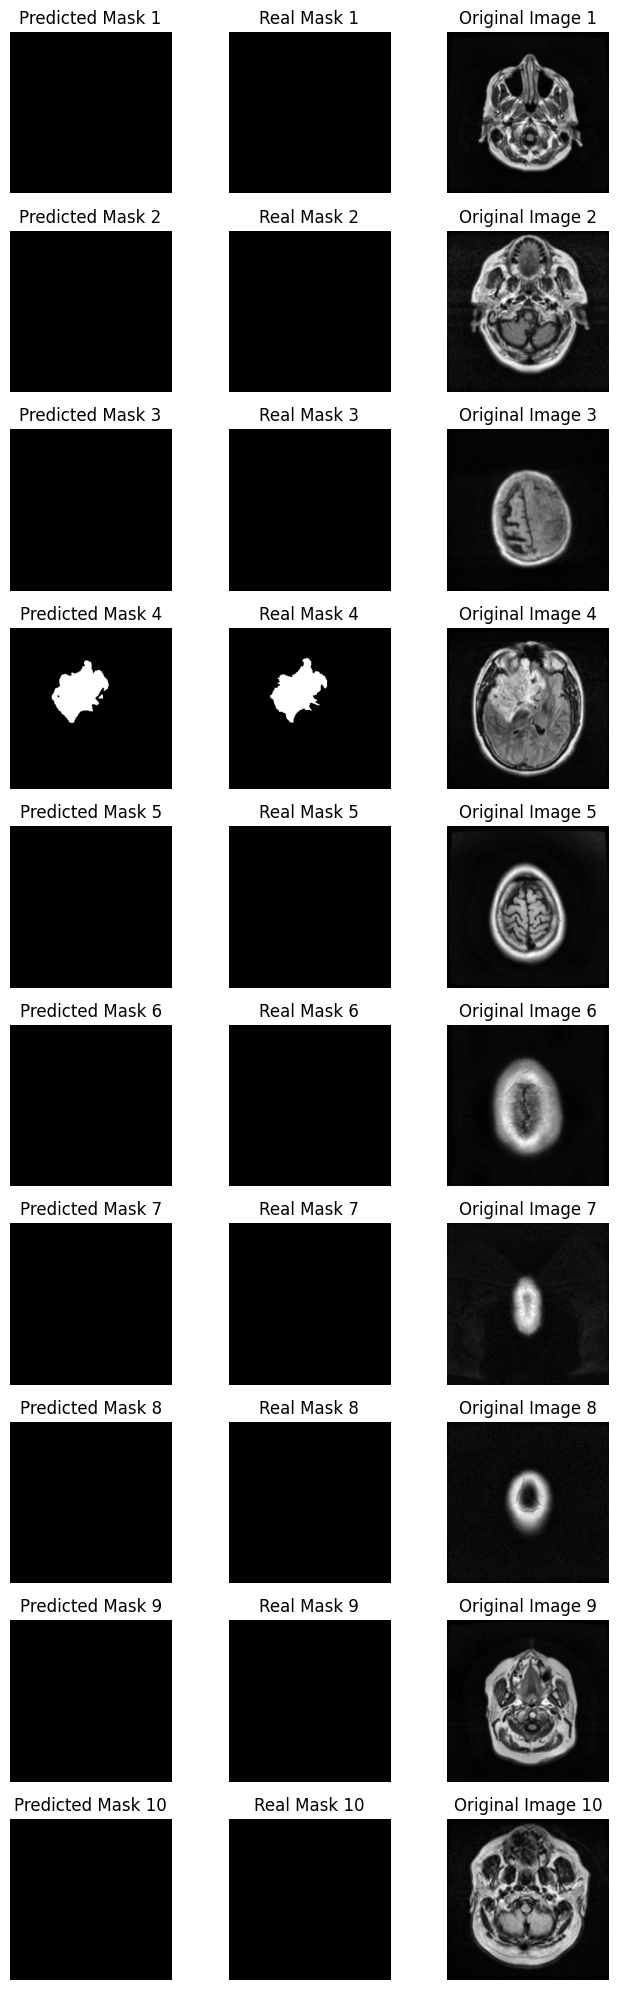

In [20]:
plot_the_result(train_y_pred, Y_train, X_train)

***
## ***results on the testset:***

In [21]:
y_pred = U_Net_model.predict(X_test)
evaluate_model_performance(Y_test, y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step
IoU: 0.6780564243413943
Dice Coefficient: 0.8081449640258894
Rand Error: 0.003940582275390625
Pixel Error: 0.003940650221652354


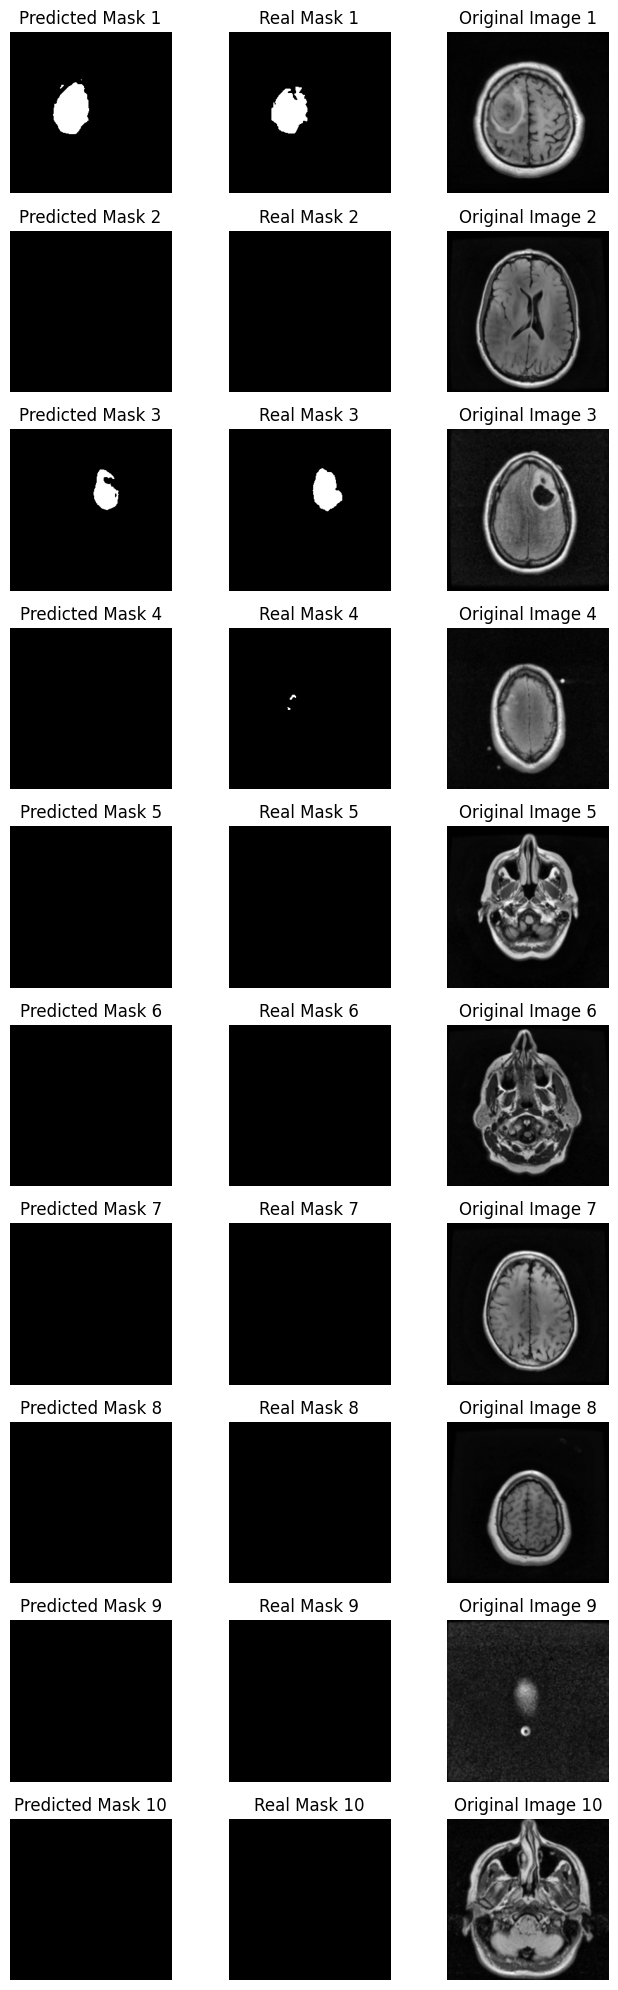

In [23]:
plot_the_result(y_pred, Y_test, X_test)

***
## ***Training the final model with 50 epochs and binary crossentropy:***

In [24]:
U_Net_model = U_Net()
U_Net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
U_Net_results = U_Net_model.fit(X_train,
                                Y_train,
                                validation_data=(X_val, Y_val),
                                batch_size=16,
                                epochs=50,
                                callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_82']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


197/197 ━━━━━━━━━━━━━━━━━━━━ 59s 211ms/step - accuracy: 0.9569 - loss: 0.1561 - val_accuracy: 0.9892 - val_loss: 0.0404
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.9897 - loss: 0.0395 - val_accuracy: 0.9892 - val_loss: 0.0406
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 147ms/step - accuracy: 0.9902 - loss: 0.0375 - val_accuracy: 0.9892 - val_loss: 0.0389
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.9898 - loss: 0.0364 - val_accuracy: 0.9892 - val_loss: 0.0352
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.9906 - loss: 0.0324 - val_accuracy: 0.9892 - val_loss: 0.0349
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 145ms/step - accuracy: 0.9902 - loss: 0.0324 - val_accuracy: 0.9892 - val_loss: 0.0300
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - accuracy: 0.9903 - loss: 0.0304 - val_accuracy: 0.9902 - val_loss: 0.0291
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.9917 - loss: 0.0251 - val

***
## ***results on the trainset:***

In [25]:
train_y_pred = U_Net_model.predict(X_train)
evaluate_model_performance(Y_train, train_y_pred)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_82']
Received: inputs=Tensor(shape=(32, 256, 256, 1))
  warnings.warn(msg)


99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step
IoU: 0.8590910571005129
Dice Coefficient: 0.9242054646213765
Rand Error: 0.0015546679496765137
Pixel Error: 0.0015546487388889993


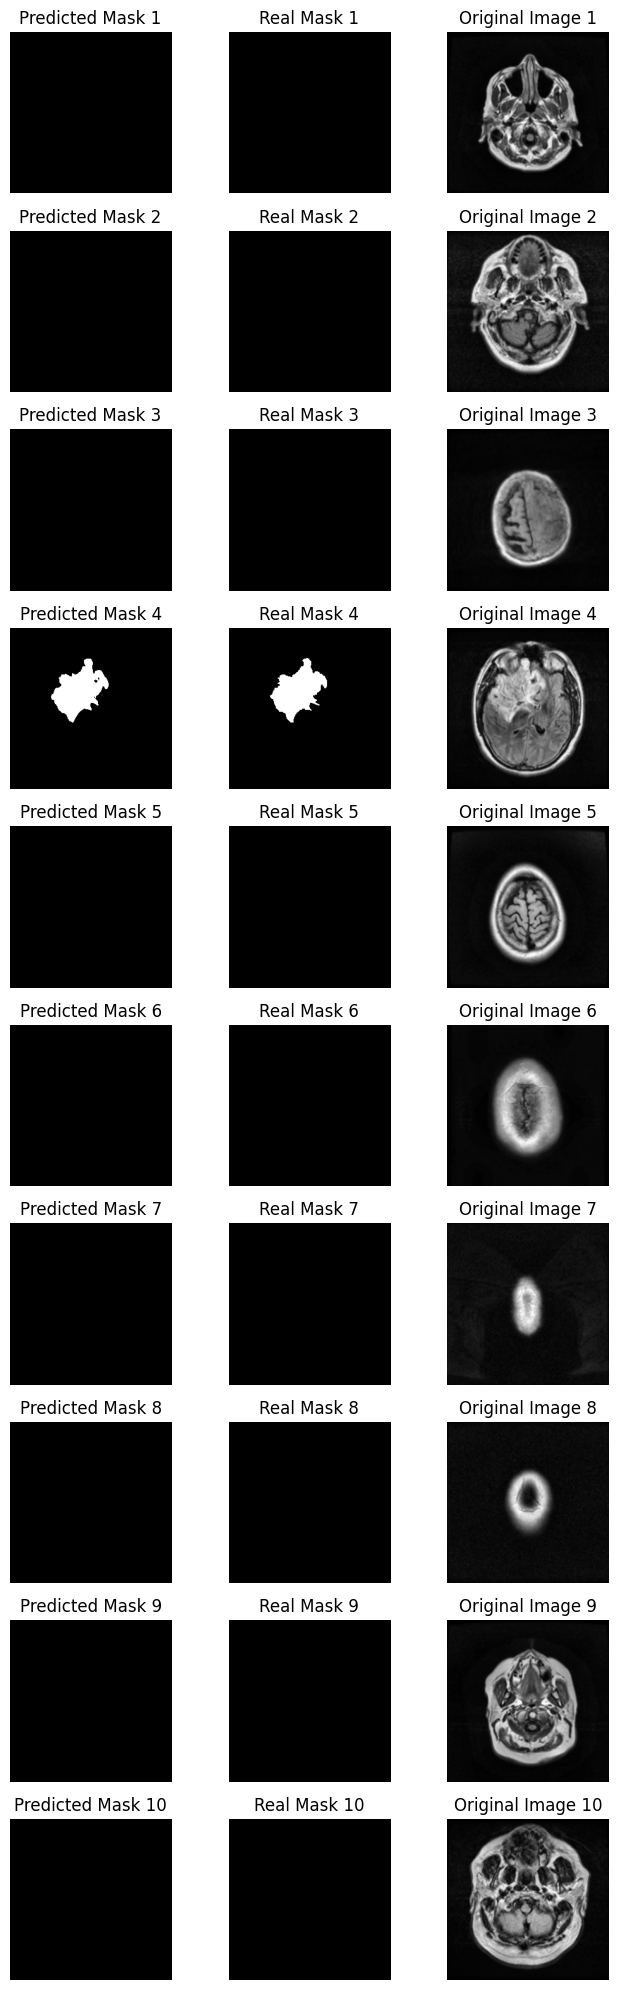

In [26]:
plot_the_result(train_y_pred, Y_train, X_train)

***
## ***results on the testset:***

In [27]:
y_pred = U_Net_model.predict(X_test)
evaluate_model_performance(Y_test, y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
IoU: 0.7734004739311859
Dice Coefficient: 0.8722231501571106
Rand Error: 0.0027622580528259277
Pixel Error: 0.0027623067375357824


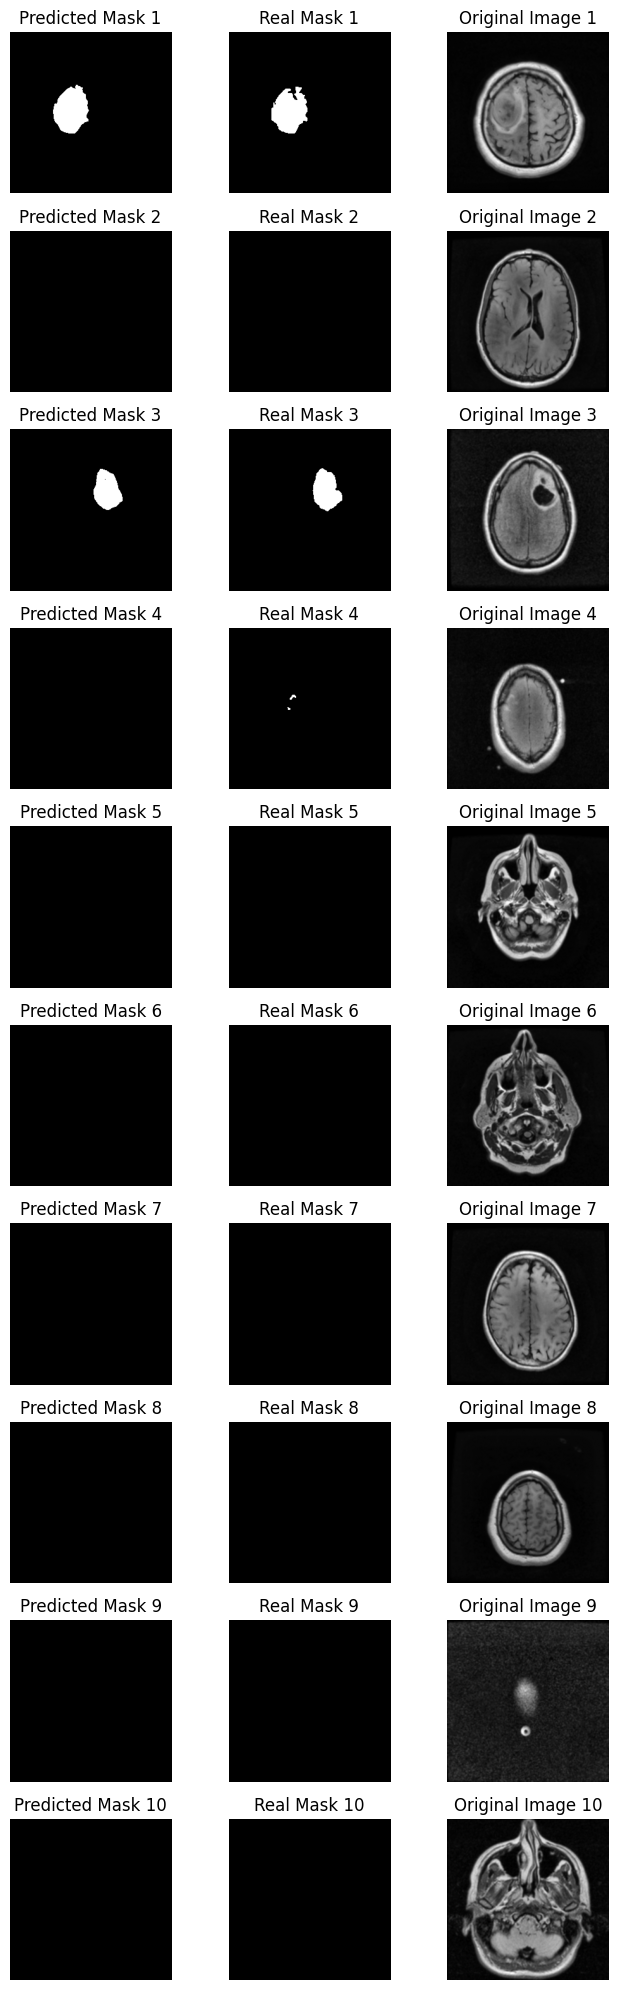

In [29]:
plot_the_result(y_pred, Y_test, X_test)

***
# ***Bonus part:***
## **Implementing U_Net model with attention gate:**

In [30]:
def attention_gate(x, g, inter_channels):
    theta_x = tf.keras.layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = tf.keras.layers.Conv2D(inter_channels, (1, 1), strides=(1, 1), padding='same')(g)

    add = tf.keras.layers.Add()([theta_x, phi_g])
    act = tf.keras.layers.Activation('relu')(add)
    psi = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(act)

    return tf.keras.layers.Multiply()([x, psi])


def U_Net_with_attention():
    f = [16, 32, 64, 128, 256]

    # Encoder
    inputs = tf.keras.layers.Input((256, 256, 1))

    c1 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = tf.keras.layers.Conv2D(f[4], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(f[4], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = tf.keras.layers.Dropout(0.3)(c5)

    # Decoder with Attention Gates
    u6 = tf.keras.layers.Conv2DTranspose(f[3], (3,3), strides=(2,2), padding='same')(c5)
    att6 = attention_gate(c4, u6, f[3])  # Attention Gate
    u6 = tf.keras.layers.Concatenate()([u6, att6])
    c6 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(f[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(f[2], (3,3), strides=(2,2), padding='same')(c6)
    att7 = attention_gate(c3, u7, f[2])
    u7 = tf.keras.layers.Concatenate()([u7, att7])
    c7 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(f[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(f[1], (3,3), strides=(2,2), padding='same')(c7)
    att8 = attention_gate(c2, u8, f[1])
    u8 = tf.keras.layers.Concatenate()([u8, att8])
    c8 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(f[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(f[0], (3,3), strides=(2,2), padding='same')(c8)
    att9 = attention_gate(c1, u9, f[0])
    u9 = tf.keras.layers.Concatenate()([u9, att9])
    c9 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(f[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


## ***Train the model using the same parameters as befor:***

In [31]:
U_Net_model = U_Net_with_attention()
U_Net_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
U_Net_model.fit(X_train,
                Y_train,
                validation_data=(X_val, Y_val),
                epochs=50,
                batch_size=16)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_123']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 266ms/step - accuracy: 0.9805 - loss: 0.1206 - val_accuracy: 0.9892 - val_loss: 0.0547
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 49s 170ms/step - accuracy: 0.9896 - loss: 0.0384 - val_accuracy: 0.9892 - val_loss: 0.0344
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.9904 - loss: 0.0329 - val_accuracy: 0.9892 - val_loss: 0.0343
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.9898 - loss: 0.0322 - val_accuracy: 0.9892 - val_loss: 0.0461
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.9906 - loss: 0.0331 - val_accuracy: 0.9921 - val_loss: 0.0281
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 33s 167ms/step - accuracy: 0.9923 - loss: 0.0243 - val_accuracy: 0.9921 - val_loss: 0.0234
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - accuracy: 0.9932 - loss: 0.0201 - val_accuracy: 0.9936 - val_loss: 0.0199
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 33s 167ms/step - accuracy: 0.9944 - loss: 0.0161 - val

***
## ***results on the trainset:***

In [32]:
train_y_pred = U_Net_model.predict(X_train)
evaluate_model_performance(Y_train, train_y_pred)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_123']
Received: inputs=Tensor(shape=(32, 256, 256, 1))
  warnings.warn(msg)


99/99 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step
IoU: 0.8330362251395279
Dice Coefficient: 0.9089140887830718
Rand Error: 0.0019351840019226074
Pixel Error: 0.0019352348830113547


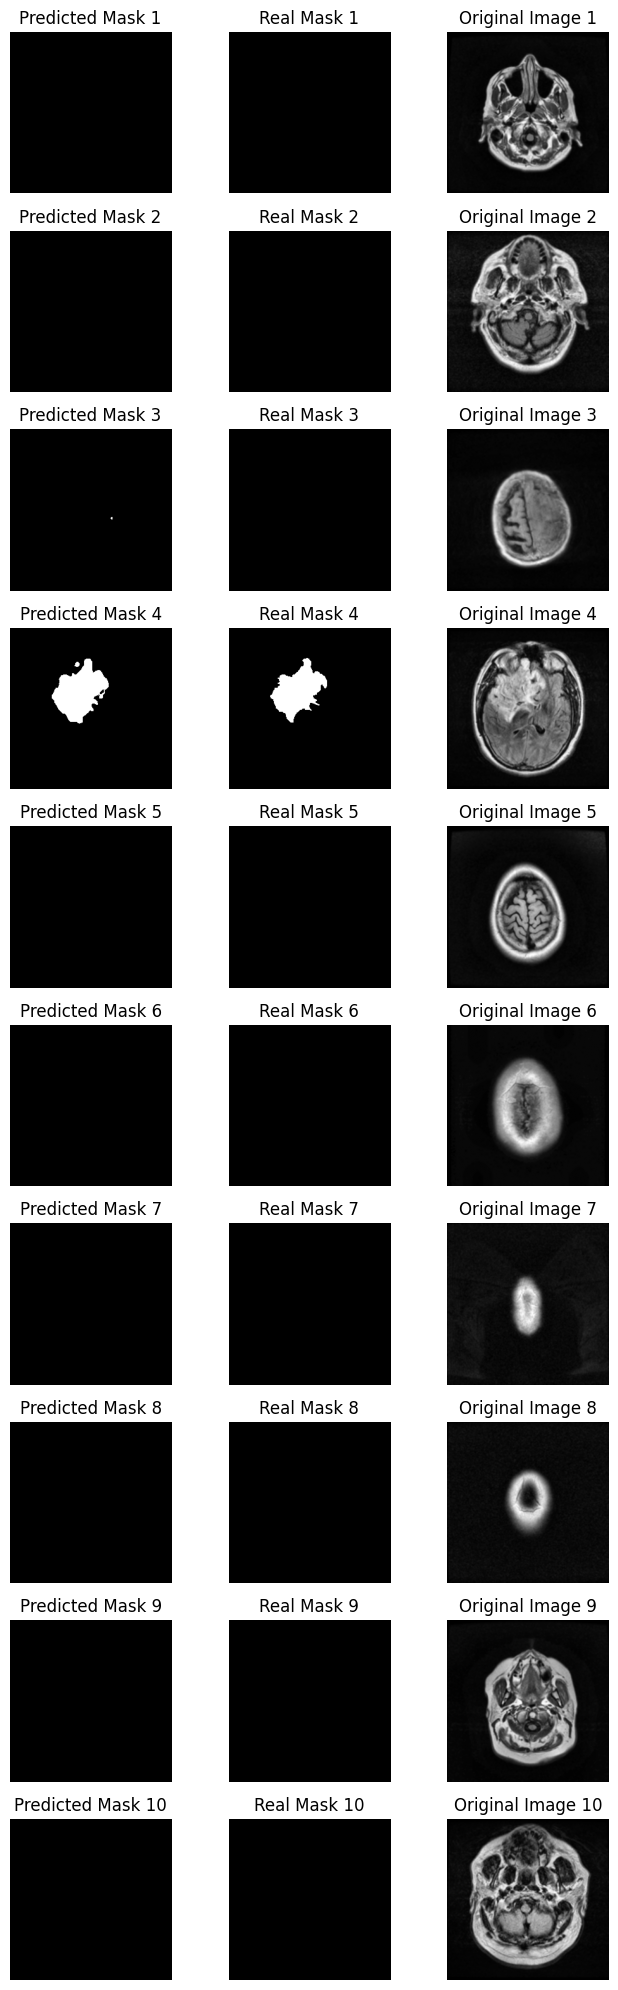

In [33]:
plot_the_result(train_y_pred, Y_train, X_train)

***
## ***results on the testset:***

In [34]:
y_pred = U_Net_model.predict(X_test)
evaluate_model_performance(Y_test, y_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step
IoU: 0.761609419013652
Dice Coefficient: 0.8646745536136915
Rand Error: 0.0031114816665649414
Pixel Error: 0.0031115505228212466


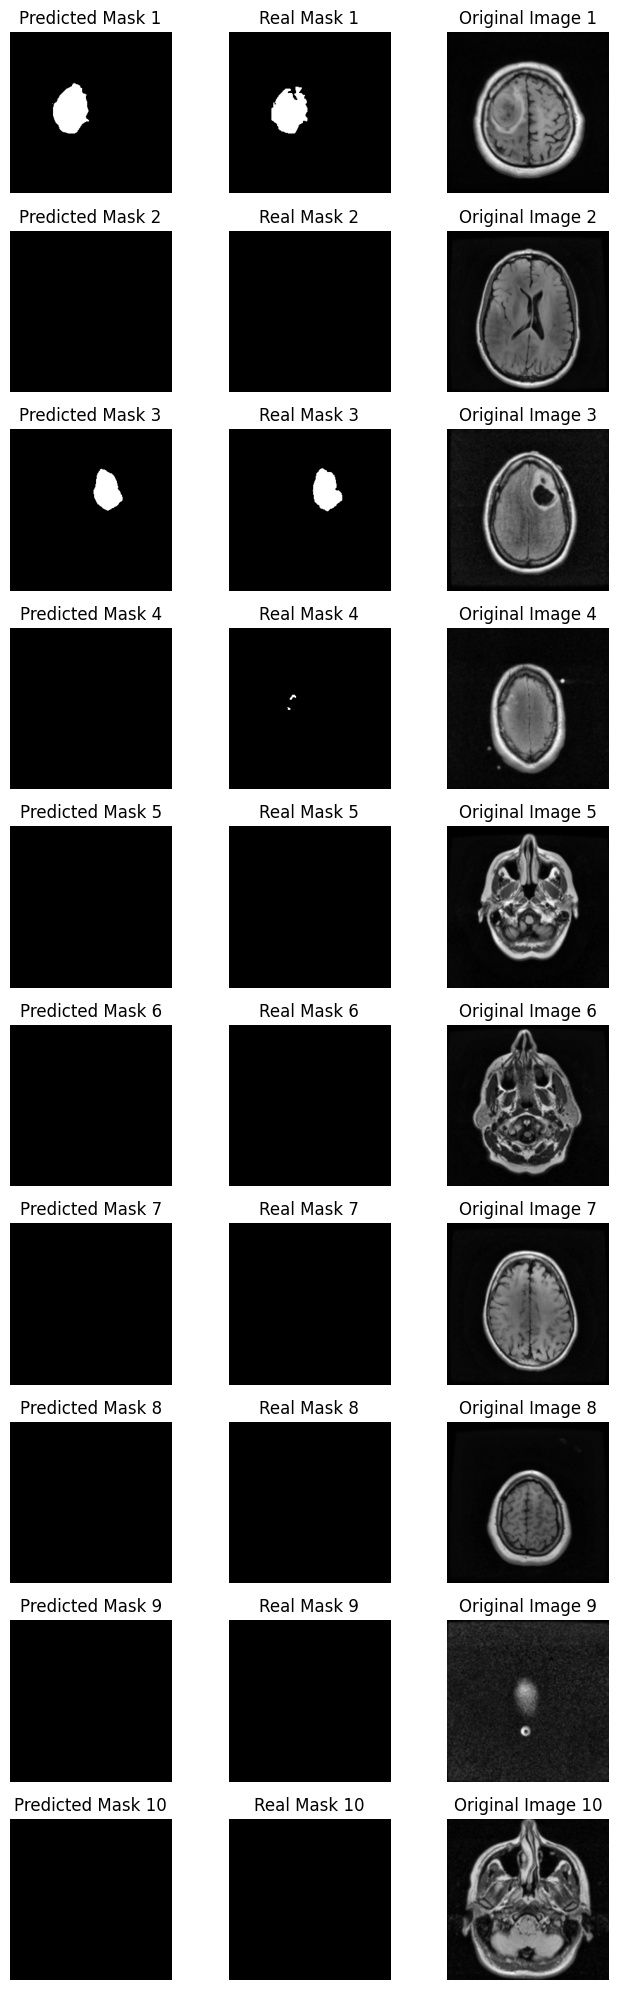

In [35]:
plot_the_result(y_pred, Y_test, X_test)